# **INFO284 Machine Learning Exam, spring 2025**


# **Task 1 - Sentiment analysis**

## **Task Description**

In task 1 of this notebook we are going to perform a sentiment analysis of hotel reviews. We are going to build 4 different machine learning models to predict and classify the sentiment of the reviews (positive or negative). The notebook is ordered in different sections, where we first load the data, explore the dataset to gain an understanding of it, perform data cleaning and preprocessing, feature extraction, and finally build and evaluate the machine learning models.

## **Load data**

In [3]:
import pandas as pd

df = pd.read_csv('dataset/Hotel_Reviews.csv')
# Creating a copy of the dataframe to preserve the original data for visualization 
df_copy = pd.read_csv('dataset/Hotel_Reviews.csv')

df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,8/3/2017,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/31/2017,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,7/24/2017,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


## **Exploring the dataset**

### **Exploring the basic structure of the dataset**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Hotel_Address                               515738 non-null  object 
 1   Additional_Number_of_Scoring                515738 non-null  int64  
 2   Review_Date                                 515738 non-null  object 
 3   Average_Score                               515738 non-null  float64
 4   Hotel_Name                                  515738 non-null  object 
 5   Reviewer_Nationality                        515738 non-null  object 
 6   Negative_Review                             515738 non-null  object 
 7   Review_Total_Negative_Word_Counts           515738 non-null  int64  
 8   Total_Number_of_Reviews                     515738 non-null  int64  
 9   Positive_Review                             515738 non-null  object 
 

The cell above shows some info about the dataset. We can see that the dataset in total contains 515,738 rows (reviews) and 17 columns containing both numerical and categorical data. We can also observe that there are some missing values, specifically in the columns "lat" and "lng" where non-null count is 512,470 out of 515,738. This means there are 3,268 missing values in these columns. All other columns have no missing values, as indicated by the "non-null" count being the same as the total row count (515,738).

For the sentiment analysis, we interpret the column Reviewer_Score as the most suitable label for the sentiment of the review. This is because the review score is a numerical value that can be used to classify the sentiment of the review as positive or negative. Assuming that higher numerical values reflect more positive reviews and lower scores reflect more negative reviews, we can use a threshold to classify reviews into "positive" or "negative" reviews. 
 

In [5]:
df[df['lat'].isna()].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
99488,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,Australia,No Negative,0,377,Upgraded rooms are excellent Good size for tr...,25,6,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99489,20 Rue De La Ga t 14th arr 75014 Paris France,22,8/3/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Noise Not being told about this when we check...,12,377,The location was great However renovations we...,45,1,6.7,"[' Leisure trip ', ' Couple ', ' Standard Room...",0 days,NaN,NaN
99490,20 Rue De La Ga t 14th arr 75014 Paris France,22,7/25/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,Room was worn down One of the curtains did no...,43,377,Location was good,5,1,5.4,"[' Leisure trip ', ' Solo traveler ', ' Standa...",9 days,NaN,NaN
99491,20 Rue De La Ga t 14th arr 75014 Paris France,22,6/22/2017,7.8,Mercure Paris Gare Montparnasse,Australia,Access to shower was by the tub which is very...,54,377,No Positive,0,13,8.3,"[' Leisure trip ', ' Couple ', ' Standard Twin...",42 days,NaN,NaN
99492,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/24/2017,7.8,Mercure Paris Gare Montparnasse,United States of America,The breakfast was way over priced and the sta...,83,377,The property was conveniently located near th...,11,2,5.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",71 days,NaN,NaN
99493,20 Rue De La Ga t 14th arr 75014 Paris France,22,5/5/2017,7.8,Mercure Paris Gare Montparnasse,Belgium,Work in progress noise no bar keys had to be ...,39,377,Comfort,2,3,5.0,"[' Leisure trip ', ' Family with young childre...",90 days,NaN,NaN
99494,20 Rue De La Ga t 14th arr 75014 Paris France,22,2/11/2017,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Max price for the bare minimum Acor Hotels ca...,67,377,Few minutes walk to Ga t Metro Montparnasse M...,46,20,5.8,"[' Business trip ', ' Couple ', ' Standard Roo...",173 day,NaN,NaN
99495,20 Rue De La Ga t 14th arr 75014 Paris France,22,12/5/2016,7.8,Mercure Paris Gare Montparnasse,United Kingdom,Ongoing refurbishment whilst we were there,8,377,Very quiet at night couldn t believe we were ...,21,1,8.8,"[' Leisure trip ', ' Couple ', ' Standard Room...",241 day,NaN,NaN
99496,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/30/2016,7.8,Mercure Paris Gare Montparnasse,France,We took a room for 3 the extra bed couch bed ...,23,377,Great location 5 min away from gare montparna...,32,34,8.3,"[' Leisure trip ', ' Family with young childre...",277 day,NaN,NaN
99497,20 Rue De La Ga t 14th arr 75014 Paris France,22,10/11/2016,7.8,Mercure Paris Gare Montparnasse,United States of America,N A Room lacking microwave a minor inconvenie...,10,377,Great neighborhood with lots of restaurants s...,22,1,10.0,"[' Leisure trip ', ' Couple ', ' Standard Room...",296 day,NaN,NaN


In the cell above, we check the first 10 rows of the dataset that contain NaN values in the lat columns, to check for any discrepancies in the data. As nothing stands out as strange in the reviews with missing values in the lat column, we do nothing, but also check (see cell below), just to be safe, that there are no rows with only NaN values in either the lat or lng column.

In [6]:
df[(df['lat'].isna()) & (df['lng'].notnull())].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng


In [7]:
df[(df['lat'].notnull()) & (df['lng'].isna())].head(10)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng


### **Overview of the distribution of the review scores** 

In [8]:
print(df['Reviewer_Score'].describe()) 

count    515738.000000
mean          8.395077
std           1.637856
min           2.500000
25%           7.500000
50%           8.800000
75%           9.600000
max          10.000000
Name: Reviewer_Score, dtype: float64


The cell above shows a statistical summary of the target column in the dataset: Reviewer_Score. This gives us valuable insight into the distribution of the data and helps us understand the range of review scores, the average score, and how the scores are distributed.
* The min = 2.5 shows that the lowest score given by any reviewer is 2.5 and max = 10.0 that the highest is 10.
* The mean = 8.4 show that the average reviewer score is around 8.4, suggesting that most reviews are positive. This is not suprising as people tend to leave reviews when they have a strong opinion, often positive rather than neutral. 
* The std (standard deviation) = 1.6 shows that the reviewer scores are fairly consistent and do not vary significantly. This means that most reviews scores are close to the average score of 8.4.
* The 25th percentile, 50th percentile and 75th percentile represent the quartiles (percentiles) of the Reviewer_Score column, showing how the scores are distributed. They indicate that
    * 25th percentile (Q1) = 7.5 → 25% of the reviews have a score below 7.5, meaning that the majority (75%) have a score above 7.5. This suggests that most of the scores are relatively high.
    * 50th percentile (Median, Q2) = 8.8 → 50% of the reviews have a score below 8.8, and 50% have a score above 8.8. This shows that the median review score is quite high, reinforcing the idea that most reviews are positive.
    * 75th percentile (Q3) = 9.6 → 75% of the reviews have a score below 9.6, meaning that 25% of the reviews are between 9.6 and 10, indicating a strong concentration of high ratings.

**Key takeaway from the statistical summary:**
* The distribution is skewed towards positive reviews, as most scores are relatively high (above 7.5). This suggests that the dataset may be imbalanced, which is something we will need to consider when building our machine learning models. 

### **Histogram showing the distribution of the review scores** 

<Axes: >

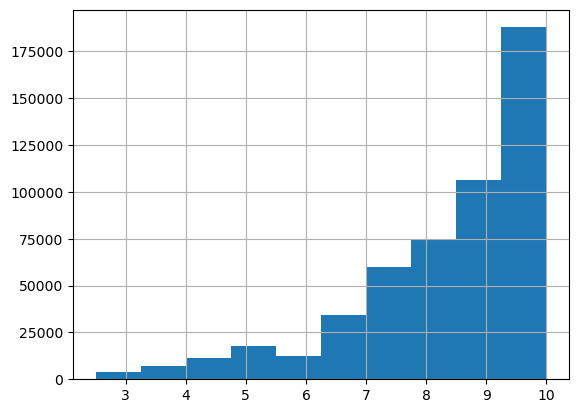

In [9]:
df['Reviewer_Score'].hist(bins=10)

In [10]:
# Print out valueCounts for each bin from 0 to 10
print(df['Reviewer_Score'].value_counts(bins=10))

(9.25, 10.0]     187807
(8.5, 9.25]      105659
(7.75, 8.5]       75277
(7.0, 7.75]       59733
(6.25, 7.0]       34502
(4.75, 5.5]       18175
(5.5, 6.25]       12304
(4.0, 4.75]       11469
(3.25, 4.0]        6979
(2.491, 3.25]      3833
Name: count, dtype: int64


From the histogram over and the distribution of the review scores in each bin we can see that the distribution of the scores is skewed towards the higher scores. This is not surprising as people tend to give higher scores when they are satisfied with a product or service as mentioned earlier. 

After understanding some basic information about the dataset, we can now move on to explore the dataset and reviews further

## **Cleaning review texts and combining the positive and negative review columns**

After exploring the dataset we find that the columns "Negative_Review" and "Positive_Review" contain the review texts. We also see that there are many rows in these columns containing the words 'No Negative' and 'No Positive'. These words are placeholders for missing data. For example, a row containing 'No Negative' in the "Negative_Review" column means that the reviewer did not leave any negative comments and vice versa for 'No Positive'. We decide to replace these words using a replace function because they are not relevant for the sentiment analysis, and will confuse our model, as we eventually plan to merge the 'Positive_Review' and 'Negative_Review' columns into one. The replace function works by replacing the words 'No Negative' and 'No Positive' with an empty string.

#### **Attempt to find a limit for positive and negative reviews**
Before we replace the 'No Negative' and 'No Positive' strings with empty strings, we try to use them to our advantage by using them to try to find a limit for where to separate the positive and negative review scores. We do this by checking the distribution of the review scores for the reviews that contain 'No Negative' and 'No Positive' in the 'Negative_Review' and 'Positive_Review' columns.

In [11]:
# print the amount of reviews where the 'Negative Review' column is 'No Negative' and the 'Positive Review' column is 'No Positive'
amount_none = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')].shape[0]

# calculate the mean and median of the 'Reviewer_Score' column for reviews where the 'Negative Review' column is 'No Negative' and the 'Positive Review' column is 'No Positive'

none_mean = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].mean()
none_median = df[(df['Negative_Review'] == 'No Negative') & (df['Positive_Review'] == 'No Positive')]['Reviewer_Score'].median()

positive_mean = df[df['Negative_Review'] == 'No Negative']['Reviewer_Score'].mean()
negative_mean = df[df['Positive_Review'] == 'No Positive']['Reviewer_Score'].mean()

positive_median = df[df['Negative_Review'] == 'No Negative']['Reviewer_Score'].median()
negative_median = df[df['Positive_Review'] == 'No Positive']['Reviewer_Score'].median()

print('Mean of no negative and no positive reviews:', none_mean)
print('Median of no negative and no positive reviews:', none_median)
print('Mean of positive reviews:', positive_mean)
print('Mean of negative reviews:', negative_mean)
print('Median of positive reviews:', positive_median)
print('Median of negative reviews:', negative_median)
print('Amount of reviews with no negative and no positive reviews:', amount_none)

# calculate the percentage of reviews that contain 'No Negative' in the 'Negative_Review' column
no_negative = df[df['Negative_Review'] == 'No Negative'].shape[0]
no_positive = df[df['Positive_Review'] == 'No Positive'].shape[0]

total = df.shape[0]

positive_percentage = no_negative / total * 100
negative_percentage = no_positive / total * 100

print('Percentage of clearly positive reviews:', positive_percentage)
print('Percentage of clearly negative reviews:', negative_percentage)

Mean of no negative and no positive reviews: 8.285826771653543
Median of no negative and no positive reviews: 8.8
Mean of positive reviews: 9.338446321057159
Mean of negative reviews: 6.886666110276526
Median of positive reviews: 9.6
Median of negative reviews: 7.1
Amount of reviews with no negative and no positive reviews: 127
Percentage of clearly positive reviews: 24.797474686759557
Percentage of clearly negative reviews: 6.96981800836859


From the data we can see that 24,7 % of all reviews contain the string 'No Negative', and have a very high median score of 9,6 and a mean score of 9,3. This suggests that reviews containing the string 'No Negative' are generally extremely positive.

On the other hand, 7 % of all reviews contain the string 'No Positive', and have a median score of 7,1 and a mean score of 6,9. This suggests that reviews containing the string 'No Positive', generally score very high as well, but not as high as reviews containing the string 'No Negative'. This can pinpoint that we should consider marking reviews with a score above 7,1 as positive, and reviews with a score below and including 7,1 as negative.

Interestingly, there are 127 reviews with no text at all, only the string 'No Negative' or 'No Positive'. These reviews have a mean score of 8,3, and a median csore of 8,8. This suggests that reviews with no text are generally positive, but not as positive as reviews with the string 'No Negative'. As they do not contain any text, we can not use them for training our model, and we will remove them from the dataset.

Now we can replace the 'No Negative' and 'No Positive' strings with empty strings, and we also drop the rows that contain no text at all - that is the rows that contain both 'No Negative' and 'No Positive'.

In [12]:
df['Negative_Review'] = df['Negative_Review'].apply(lambda x: x.replace('No Negative', ''))
df['Positive_Review'] = df['Positive_Review'].apply(lambda x: x.replace('No Positive', ''))

# drop rows where 'Negative_Review' and 'Positive_Review' are both empty
df = df[(df['Negative_Review'] != '') | (df['Positive_Review'] != '')]

## **Exploring Swedish reviews**

After analyzing the dataset, we discover that the swedes enjoy writing in their native language. Therefore we decide to get a more in depth understanding of swedish reviews.

In [13]:
print(df_copy['Reviewer_Nationality'].value_counts()[' Sweden '])

df_copy['Review'] = df_copy['Negative_Review'] + ' ' + df_copy['Positive_Review']

3368


In the cell above we decide to combine the 'Negative_Review' and 'Positive_Review' columns into one column called 'Review' because it makes it easier to work with the data and we use this column in the cell below to print out spesific swedish reviews.

In [14]:
print('1.' + df_copy.loc[224965, 'Review'] + '\n')
print('2.' + df_copy.loc[102335, 'Review'] + '\n')
print('3.' + df_copy.loc[514238, 'Review'] + '\n')
print('4.' + df_copy.loc[44876, 'Review'] + '\n')
print('5.' + df_copy.loc[381438, 'Review'] + '\n')

1. Rummet var litet Toalett utan handfat Tr ngt badrum D lig frukost utan gr nsaker Liten pool i ett annat hus S sm f rvaringssk p   Bra l ge N ra till Eiffeltornet floden och nya k pcentrum 

2. H rd s ng var enda minus under vistelsen   Utm rkt l ge p hotellet Kort g avst nd fr n tinnelbanan och bussen alldeles utanf r d rren Ett extra plus var att en buss gick direkt till westfield gallerian med shopping i m ngder 

3. Sv rt att f rst och g ra sig f rst dd hos personalen vars engelska ibland var v ldigt bristf llig   J ttegod frukost med stort utbud 

4. S ngarna var f r h rda i min smak Omgivningarna best r av nyare byggnader med m nga kontorshus s det r inte s charmig del av London   Trevlig v lst dat rum i engelsk stil Fint badrum Ett plus att man dagligen fick tv l och tv vatten i kylsk pet gratis Mycket positiv och trevlig personal i matsalen Frukosten var bra eftersom man fick v lja ett varmt alternativ fr n menyn annars hade det blivit lite magert med enbart buffe N ra till t

So there are 3368 reviews written by Swedes and as we can see some of them are written in a strange, confusing way with a lot of nonsense words.

Before we potentially remove these reviews, we want to get some insight into the sentiment of the words the swedes use in their reviews. This is done to see if the swedish reviews tend to be more positive or negative. We do this by exploring the column "Review_Total_Positive_Word_Counts", and "Review_Total_Negative_Word_Counts". With these columns, we can calculate the sum of positive and negative words used in the swedish reviews.

In [15]:
swedish_reviews = df_copy[df_copy['Reviewer_Nationality'] == ' Sweden ']
total_negative_words = swedish_reviews['Review_Total_Negative_Word_Counts'].sum()
total_positive_words = swedish_reviews['Review_Total_Positive_Word_Counts'].sum()

print('Total number of negative words in Swedish reviews:', total_negative_words)
print('Total number of positive words in Swedish reviews:', total_positive_words)

Total number of negative words in Swedish reviews: 72640
Total number of positive words in Swedish reviews: 64246


As we can see from the cell above, the swedish reviews tend to use positive and negative words relatively equally. However we decide to remove the swedish reviews from the dataset as they are written in a confusing way and contain a lot of nonsense words. This is not a huge loss, and we believe that the model will perform better without these reviews.

In [16]:
# Dropping swedish reviews
df = df[df['Reviewer_Nationality'] != ' Sweden ']

## **Transforming review scores to binary values**

Here we add a new column called 'Sentiment' which is 1 if the reviewer score is greater than 7,1 and 0 if the reviewer score is less than or equal to 7,1. This is done to transform the review scores from coninuous numerical values into binary values, where 1 represents a positive review and 0 represents a negative review. We choose 7,1 as the threshold because it is the median score for reviews containing the string 'No Positive'. Heavy weight is placed on this value as it would seem that having nothing positive to say about a hotel, but only negative things is a strong indicator of a negative review. 

In [17]:
df['Sentiment'] = df['Reviewer_Score'].apply(lambda x: 1 if x >= 7.1 else 0)

print(df['Sentiment'].value_counts())

Sentiment
1    425675
0     86568
Name: count, dtype: int64


From the value counts of the 'Sentiment' column we can see that the dataset is imbalanced, with approximately 80% of the reviews being positive and approximately 20% being negative. This is something we need to consider when building our machine learning models, as the models may be biased towards predicting positive reviews.

## **Preprocessing the review text**

### **Stopwords removal**

A very important part of text preprocessing is the removal of stopwords. We will first check the most common words in the positive and negative reviews, to get an overview before we eventually remove them. Stopwords needs to be removed because they are common words that doesnt carry any sentiment value

In [18]:
import pandas as pd
from nltk.corpus import stopwords

stop = stopwords.words('english')

# Function to give the top 10 most common words in a column 
def most_common_words(text):
    words = dict()
    for word in text:
        for w in word.split():
            if w in words and w != '':
                words[w] += 1
            else:
                words[w] = 1
    words = dict(sorted(words.items(), key=lambda item: item[1], reverse=True))
    return list(words.keys())[:10]

# get the most common words in the 'Positive Review' column
most_common_positive = most_common_words(df['Positive_Review'])
most_common_negative = most_common_words(df['Negative_Review'])

print('Most common words in positive reviews:')
print(most_common_positive)
print('\n')
print('Most common words in negative reviews:')
print(most_common_negative)

Most common words in positive reviews:
['and', 'the', 'was', 'to', 'The', 'a', 'staff', 'very', 'location', 'room']


Most common words in negative reviews:
['the', 'was', 'to', 'a', 'and', 'in', 'room', 'of', 'for', 'not']


Here we can see that the most common words in both the positive and negative reviews are stopwords. This is not surprising, as stopwords are common words. But they do not carry any sentiment value, and should be removed. We will remove the stopwords from the reviews and then again explore the 10 most common words in both columns. 

In removing the stopwords we also make sure to not remove the words 'no', 'not' and 'never' as they are important for sentiment analysis, as they are negation words and can drastically change the sentiment of a sentence.

In [19]:
stopwords_removed = dict()

def remove_stopwords_and_count(text):
    # remove stopwords, and add the removed words to the stopwords_removed set
    cleaned_text = ' '.join([word for word in text.split() if word.lower() not in stop or word.lower() in ['no', 'not', 'never']])
    for word in text.split():
        if word.lower() in stop and word.lower() not in ['no', 'not', 'never']:
            if word.lower() in stopwords_removed:
                stopwords_removed[word.lower()] += 1
            else:
                stopwords_removed[word.lower()] = 1
    return cleaned_text

df['positive_review_cleaned'] = df['Positive_Review'].apply(lambda x: remove_stopwords_and_count(x))
df['negative_review_cleaned'] = df['Negative_Review'].apply(lambda x: remove_stopwords_and_count(x))

most_common_positive_cleaned = most_common_words(df['positive_review_cleaned'])
most_common_negative_cleaned = most_common_words(df['negative_review_cleaned'])

print('Most common words in positive reviews after removing stopwords:')
print(most_common_positive_cleaned)
print('\n')
print('Most common words in negative reviews after removing stopwords:')
print(most_common_negative_cleaned)

Most common words in positive reviews after removing stopwords:
['staff', 'location', 'room', 'hotel', 'good', 'helpful', 'friendly', 'great', 'breakfast', 'clean']


Most common words in negative reviews after removing stopwords:
['room', 'not', 'hotel', 'small', 'no', 'breakfast', 'staff', 'could', 'would', 'Nothing']


We observe that after supposedly removing stopwords, we still have some stragglers that are not useful for our model, such as 'could' and 'would'. We will remove these as well as they are not useful for our model.

In [20]:
# function to remove specific words from a text
def remove_specific_words(text, words):
    for word in words:
        text = text.replace(word, '')
    return text

# remove 'The' and 'I' from both the positive and negative reviews
df['positive_review_cleaned'] = df['positive_review_cleaned'].apply(lambda x: remove_specific_words(x, ['could', 'would']))
df['negative_review_cleaned'] = df['negative_review_cleaned'].apply(lambda x: remove_specific_words(x, ['could', 'would']))

most_common_positive_cleaned = most_common_words(df['positive_review_cleaned'])
most_common_negative_cleaned = most_common_words(df['negative_review_cleaned'])

print('Most common words in positive reviews after removing stopwords and specific words:')
print(most_common_positive_cleaned)
print('\n')
print('Most common words in negative reviews after removing stopwords and specific words:')
print(most_common_negative_cleaned)

Most common words in positive reviews after removing stopwords and specific words:
['staff', 'location', 'room', 'hotel', 'good', 'helpful', 'friendly', 'great', 'breakfast', 'clean']


Most common words in negative reviews after removing stopwords and specific words:
['room', 'not', 'hotel', 'small', 'no', 'breakfast', 'staff', 'Nothing', 'rooms', 'bit']


We can observe that one of the most common words in the negative reviews is the word "Nothing", which appears alone and seems to indicate that the reviewer actually has nothing negative to say about the hotel, but instead of leaving it blank so the placeholder "No Negative" can appear, they have chosen to manually write "Nothing". This is a problem, as it is harder to sort out and replace these words with '', as they are common words used in very different sentences and contexts. 

In [21]:
# count the number of reviews where the 'Negative_Review' column only contains the word 'nothing'
no_negative = df[df['Negative_Review'].apply(lambda x: x.lower().strip() in ['nothing', 'none'])].shape[0]

# count the number of reviews where the 'Positive_Review' column only contains the word 'no', 'nothing' or 'none'
no_positive = df[df['Positive_Review'].apply(lambda x: x.lower().strip() in ['nothing', 'none'])].shape[0]

print('Number of reviews with only the word "no", "nothing" or "none" in the Negative_Review column:', no_negative)
print('Number of reviews with only the word "no", "nothing" or "none" in the Positive_Review column:', no_positive)

Number of reviews with only the word "no", "nothing" or "none" in the Negative_Review column: 22627
Number of reviews with only the word "no", "nothing" or "none" in the Positive_Review column: 1762


We can observe that there are many reviews that only contain a negative word, suggesting that the reviewer has actually not written any review, and it will be most useful to just replace the text with ''. .

In [22]:
import re

df['Negative_Review'] = df['Negative_Review'].apply(
    lambda x: '' if re.fullmatch(r'\b(nothing|no|none)\b', x, flags=re.IGNORECASE) else x
)
df['Positive_Review'] = df['Positive_Review'].apply(
    lambda x: '' if re.fullmatch(r'\b(nothing|no|none)\b', x, flags=re.IGNORECASE) else x
)

Now we need to make sure that there hasn't been created any rows with empty reviews. If there are, we remove them.

In [23]:
# count the number of rows where both the 'Negative_Review' and 'Positive_Review' columns are empty
empty_reviews = df[(df['Negative_Review'] == '') & (df['Positive_Review'] == '')].shape[0]

print('Number of rows where both the Negative_Review and Positive_Review columns are empty:', empty_reviews)

Number of rows where both the Negative_Review and Positive_Review columns are empty: 0


In [24]:
# print the amount of unique stopwords removed
print("Total of unique stopwords removed:", len(stopwords_removed))
# print the 10 most common stopwords removed
print("Most common stopwords removed:", sorted(stopwords_removed.items(), key=lambda x: x[1], reverse=True)[:10])
print("Total amount stopwords removed:", sum(stopwords_removed.values()))

Total of unique stopwords removed: 151
Most common stopwords removed: [('the', 1038469), ('and', 635457), ('was', 470590), ('to', 413738), ('a', 392172), ('in', 279723), ('very', 271513), ('of', 226058), ('for', 207368), ('is', 183249)]
Total amount stopwords removed: 7531123


In [25]:
# Show the number of rows in the dataframe
print(df.shape[0]) 

512243


The total number of stopwords that was removed is 7 531 123. So from the 512 370 number of rows in the dataset, on average, approximately 15 stopwords were removed from each row.
On average, each review has a significant number of words that don't carry much meaning for our analysis. The fact that so many stopwords were removed indicates that the reviews are likely composed of relatively lengthy or detailed sentences, with frequent usage of common words. The process of removing these stopwords is crucial for the analysis, as it allows us to focus on the words that are more likely to carry sentiment.

### **Combining and Cleaning the review texts**

After removing stopwords we need to do further cleaning of the review texts. We will remove special characters, punctuation and anything that matches: !"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~, using punctuations and regex. We will also convert all the text to lowercase to ensure that the model does not treat words with different cases as different words.

In [26]:
import re
import string 

df['Review'] = df['Negative_Review'] + ' ' + df['Positive_Review']

def preprocess_text(cleaned_text):
    cleaned_text = cleaned_text.lower().strip()
    cleaned_text = re.sub(f"[{string.punctuation}]", "", cleaned_text)
    return cleaned_text

df['Review'] = df['Review'].apply(preprocess_text)
df[['Review']].head()


,Review
0,i am so angry that i made this post available ...
1,no real complaints the hotel was great great l...
2,rooms are nice but for elderly a bit difficult...
3,my room was dirty and i was afraid to walk bar...
4,you when i booked with your company on line yo...


### **Converting numbers to words**
Many of the reviews contain numbers that will be difficult for our models to interpret. We will convert these numbers to words, to better take advantage of the information they contain.

In [27]:
print(df_copy.loc[5512, 'Review'])

def convert_numbers(text):
    text = re.sub(r'\b[1-5]\b', 'NUM_LOW', text)
    text = re.sub(r'\b[6-9]|10\b', 'NUM_HIGH', text)
    return text

df['Review'] = df['Review'].apply(convert_numbers)
df.loc[5512, 'Review']

No Negative  I would not normally Mark somewhere 10 out of 10 but as soon as we got there the staff were friendly and helpful the room was excellent There was a nice seating area outside where the wife could have a smoke while we had a drink When we went out in the evening there was a good selection of bars and restaurants within a short walking distance In the morning there was a good selection for breakfast we both had a full English breakfast which was cooked to perfection 


'i would not normally mark somewhere NUM_HIGH out of NUM_HIGH but as soon as we got there the staff were friendly and helpful the room was excellent there was a nice seating area outside where the wife could have a smoke while we had a drink when we went out in the evening there was a good selection of bars and restaurants within a short walking distance in the morning there was a good selection for breakfast we both had a full english breakfast which was cooked to perfection'

### **Tokenization**

Here we tokenize the review text by splitting the text into individual words. This needs to be done to prepare the text for the next step, which is lemmatization because lemmatization requires tokenized text as input. Tokenization breaks down the text to smaller more managaable parts making it easier to analyze the text. 

In [28]:
from nltk.tokenize import word_tokenize

def tokenize(text):
    return word_tokenize(text)

df['tokens'] = df['Review'].apply(tokenize)
df[['tokens']].head() 

,tokens
0,"[i, am, so, angry, that, i, made, this, post, ..."
1,"[no, real, complaints, the, hotel, was, great,..."
2,"[rooms, are, nice, but, for, elderly, a, bit, ..."
3,"[my, room, was, dirty, and, i, was, afraid, to..."
4,"[you, when, i, booked, with, your, company, on..."


### **Lemmatization**

Here we do lemmatization on the tokenized text. Lemmatization is the process of reducing words to their base or root form. This is done to reduce the number of unique words in the text, making it easier to analyze and understand. By removing grammatical variations of words, we can focus on the core meaning of the words, which is important for sentiment analysis.

In [29]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize(tokens):
    lemmatized_tokens = []
    for token in tokens:
        lemmatized_token = lemmatizer.lemmatize(token)
        lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

df['lemmatized'] = df['tokens'].apply(lemmatize)

df[['lemmatized']].head() 

,lemmatized
0,"[i, am, so, angry, that, i, made, this, post, ..."
1,"[no, real, complaint, the, hotel, wa, great, g..."
2,"[room, are, nice, but, for, elderly, a, bit, d..."
3,"[my, room, wa, dirty, and, i, wa, afraid, to, ..."
4,"[you, when, i, booked, with, your, company, on..."


## **Splitting the data into training and test sets**

Before we run the different algorithms on the dataset, we need to split the data into training and testing data. We will use the lemmatized column as the feature. This column contains the preprocessed review text, which we will use to train the machine learning models. We will use the 'Sentiment' column as the target, which contains the binary values (0 or 1) indicating whether the review is positive or negative.

In [30]:

from sklearn.model_selection import train_test_split

X = df['lemmatized'].apply(lambda x: ' '.join(x))

y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

df[['lemmatized', 'Sentiment']].head() 

,lemmatized,Sentiment
0,"[i, am, so, angry, that, i, made, this, post, ...",0
1,"[no, real, complaint, the, hotel, wa, great, g...",1
2,"[room, are, nice, but, for, elderly, a, bit, d...",1
3,"[my, room, wa, dirty, and, i, wa, afraid, to, ...",0
4,"[you, when, i, booked, with, your, company, on...",0


## **MultinomialNB**

### **MultinomialNB with TF-IDF vectorizer**

The first model we will use for classifiying hotel reviews is MultinomialNB with TF-IDF vectorizer. We will use the TF-IDF vectorizer to convert the text data into numerical data that the model can work with. This model is chosen because it is a simple and fast model that is often used for text classification tasks. 

#### **Importing necessary libraries**

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

#### **Creating pipeline**
Because we are using TF-IDF vectorizer, it is most beneficial to use a pipeline because we are transforming the text data based on statistical properties of the dataset. Because of this, it's essential to ensure that all steps (vectorization and model training) are done correctly and consistently. 

For our vectorizer we set the min_df parameter to 5. This means that we only include words in the vocabulary that appear in at least 5 reviews. This is done to remove words that are too rare, as they are unlikely to carry much meaning for the model. 
In addition we set the max_df parameter to 0.8. This means that we only include words in the vocabulary that appear in a maximum of 80% of the reviews. This is done to remove words that are too common, as they are unlikely to carry much meaning for the model. 
We set the norm param to l2. This ensures that the vectorizer balances the influence of review length and word frequencies. It helps the model focus on relative word importance and ensures better generalization.

In [85]:
pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm='l2'), MultinomialNB())

param_grid = {'multinomialnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', refit=True, n_jobs=-1)

grid.fit(X_train, y_train)

print("Best parameters:\n{}".format(grid.best_params_))
print("Best cross-validation score:\n{:.2f}".format(grid.best_score_))
print("Best estimator:\n{}".format(grid.best_estimator_))

Best parameters:
{'multinomialnb__alpha': 1, 'tfidfvectorizer__ngram_range': (1, 2)}
Best cross-validation score:
0.93
Best estimator:
Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.8, min_df=5, ngram_range=(1, 2))),
                ('multinomialnb', MultinomialNB(alpha=1))])


#### **Heat map of f1-score as a function of ngram range and alpha values** 

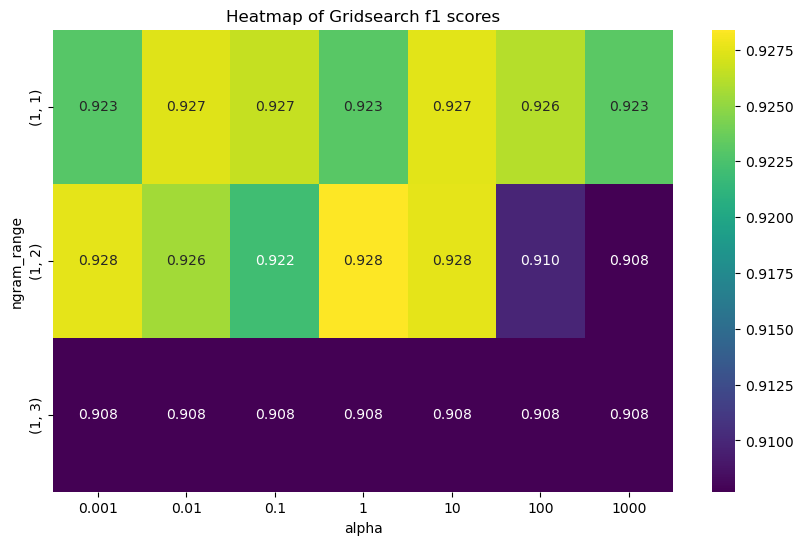

In [86]:
# Get the number of unique values for each parameter
n_ngram_range = len(param_grid['tfidfvectorizer__ngram_range'])
n_alpha = len(param_grid['multinomialnb__alpha'])

# Reshape the scores array based on the number of unique values
scores = grid.cv_results_['mean_test_score'][:n_ngram_range * n_alpha].reshape(n_ngram_range, n_alpha)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=param_grid['multinomialnb__alpha'], yticklabels=param_grid['tfidfvectorizer__ngram_range'], cmap='viridis')
plt.xlabel('alpha')
plt.ylabel('ngram_range')
plt.title('Heatmap of Gridsearch f1 scores')
plt.show()

The highest F1 score (~0.93) is achieved when alpha=1 and ngram_range=(1,2), as also confirmed by grid.best_params_. This suggests that including bigrams (in addition to unigrams) improves the model's performance.

Small alpha values (0.001, 0.01, 0.1, 1) generally yield good performance.
Very large alpha values (100, 1000) lead to a significant drop in F1 score, especially for ngram_range=(1,2), indicating over-smoothing.

ngram_range=(1,1) (unigrams) performs well across different alpha values, but slightly worse than (1,2).
ngram_range=(1,3) (including trigrams) consistently has the lowest scores (~0.908), indicating that trigrams do not add value for this classification task and may introduce noise.
General Trends:

The performance of (1,1) and (1,2) is relatively stable across moderate values of alpha (up to 10).
The performance of (1,3) remains consistently lower, suggesting diminishing returns when incorporating longer n-grams.

The best model uses ngram_range=(1,2) and alpha=1. Including bigrams improves classification performance, while trigrams do not help. Very high alpha values hurt performance, likely due to excessive smoothing. If optimizing for performance, it is best to avoid large alpha values and unnecessary trigrams.

The lowest row corresponds to ngram_range=(1,3), and all its F1 scores are the same (0.908) regardless of the alpha value. This suggests a few key insights:

Unlike unigrams and bigrams, which show variations in F1 scores depending on alpha, the trigram-based model performs consistently at 0.908. This indicates that adding trigrams does not provide additional discriminative power for this task.

Trigrams are inherently less frequent than unigrams or bigrams, which may lead to a sparse feature space. Naïve Bayes (especially with TF-IDF) tends to downweight rare features, making the contribution of trigrams negligible.

Since all values in this row are identical, it means that changing alpha does not affect performance when using trigrams. This suggests that the smoothing parameter has little to no influence when most of the feature space consists of higher-order n-grams.

Using trigrams is unnecessary for this classification task — it does not improve performance and only adds computational complexity. Feature selection should prioritize unigrams and bigrams, as they show meaningful variation and achieve higher F1 scores.


#### **Evaluation of the model**

              precision    recall  f1-score   support

           0       0.76      0.39      0.52     17314
           1       0.89      0.97      0.93     85135

    accuracy                           0.88    102449
   macro avg       0.82      0.68      0.72    102449
weighted avg       0.87      0.88      0.86    102449



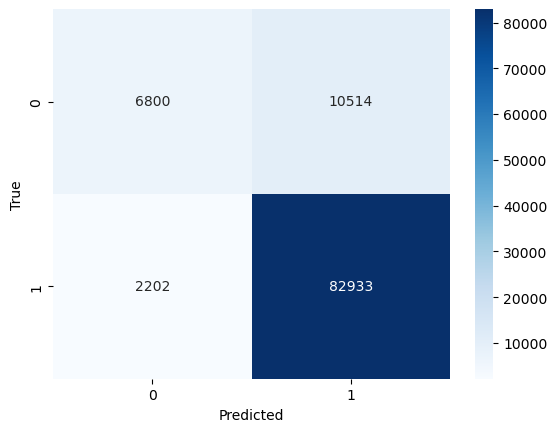

In [87]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### **Precision-recall curve evaluation**
Since the dataset is imbalanced, we will use the precision-recall curve to evaluate the model. The precision-recall curve is a better evaluation metric for imbalanced datasets than the ROC curve, as it focuses on the positive class (minority class) and is not affected by the class imbalance. The precision-recall curve shows the trade-off between precision and recall for different thresholds. We can see that the model has a high precision and recall for positive reviews, but a lower precision and recall for negative reviews. This is likely due to the class imbalance in the dataset, as the model is biased towards predicting positive reviews. 
The PR curve focuses on the minority class of the dataset, which in our case is negative reviews. The PR curve helps us pick the best threshold for our model.

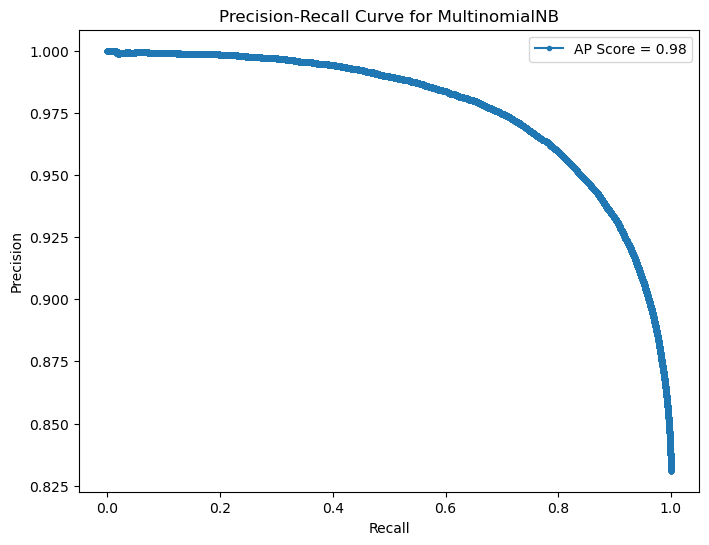

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class (assuming binary classification)
y_scores = grid.predict_proba(X_test)[:, 1]  # Get probabilities for class 1

# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AP Score = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for MultinomialNB')
plt.legend()
plt.show()

#### **Visualizing the top features that are most indicative of positive and negative reviews**

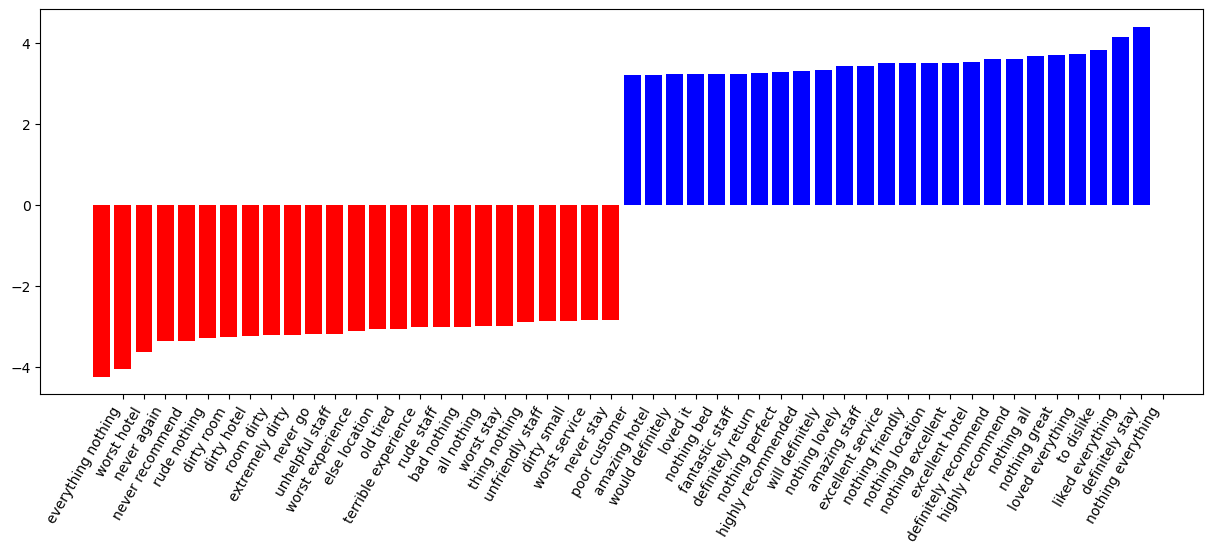

In [89]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    top_positive_coefficients = np.argsort(coef)[-n_top_features:]
    top_negative_coefficients = np.argsort(coef)[:n_top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
clf = grid.best_estimator_.named_steps['multinomialnb']
visualize_coefficients(clf, vectorizer.get_feature_names_out())

The visualization show the top 20 features that are most indicative of positive and negative reviews. The features are sorted by their coefficient values. The features with the highest coefficient values are most indicative of positive reviews, while the features with the lowest coefficient values are most indicative of negative reviews.

#### **Summarizing the model performance**
skriv her

## **Complement Naive Bayes with TF-IDF vectorizer**

### **Creating pipeline**

In [ ]:
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import KFold

pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm=None), ComplementNB())

param_grid = {'complementnb__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring='f1', refit=True)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

{'complementnb__alpha': 100, 'tfidfvectorizer__ngram_range': (1, 3)}
0.905232057909165
0.9053516013818139


In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### **Heat map of mean cross-validation f1 score as a function of the parameters ngram_range and alpha**

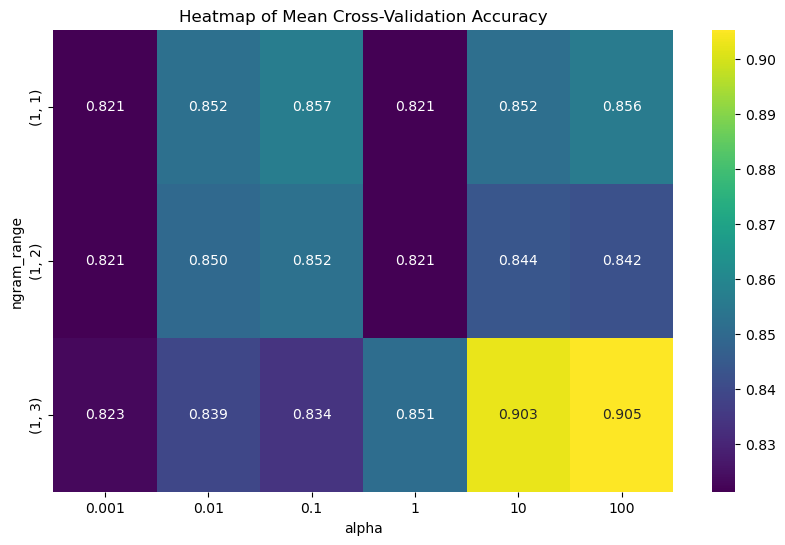

In [ ]:
# Get the number of unique values for each parameter
n_ngram_range = len(param_grid['tfidfvectorizer__ngram_range'])
n_alpha = len(param_grid['complementnb__alpha'])

# Reshape the scores array based on the number of unique values
scores = grid.cv_results_['mean_test_score'][:n_ngram_range * n_alpha].reshape(n_ngram_range, n_alpha)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=param_grid['complementnb__alpha'], yticklabels=param_grid['tfidfvectorizer__ngram_range'], cmap='viridis')
plt.xlabel('alpha')
plt.ylabel('ngram_range')
plt.title('Heatmap of Gridsearch f1 scores')
plt.show()

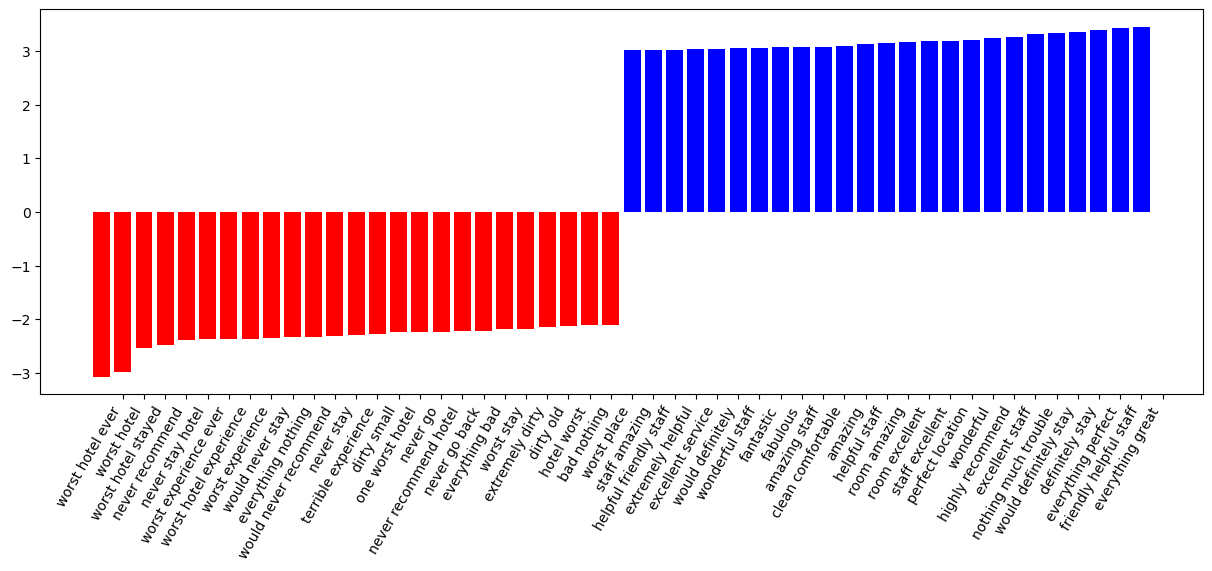

In [33]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    top_positive_coefficients = np.argsort(coef)[-n_top_features:]
    top_negative_coefficients = np.argsort(coef)[:n_top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
clf = grid.best_estimator_.named_steps['complementnb']
visualize_coefficients(clf, vectorizer.get_feature_names_out())


## **SVM with TF-IDF vectorizer**

### **Creating pipeline**

In [36]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold

pipe = make_pipeline(TfidfVectorizer(min_df = 5, max_df=0.8, norm='l2'), LinearSVC())

param_grid = {'linearsvc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid, cv=kfold, scoring='f1', refit=True, n_jobs=-1)

grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)
print(grid.score(X_test, y_test))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Get predicted probabilities for the positive class (assuming binary classification)
y_scores = grid.decision_function(X_test)  # Get probabilities

# Compute precision-recall values

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
ap_score = average_precision_score(y_test, y_scores)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AP Score = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for LinearSVC')
plt.legend()
plt.show()

In [ ]:
# plot decision boundary

from sklearn.inspection import DecisionBoundaryDisplay

X_train_transformed = grid.best_estimator_.named_steps['tfidfvectorizer'].transform(X_train)
clf = grid.best_estimator_.named_steps['linearsvc']

display = DecisionBoundaryDisplay.from_estimator(clf, X_train_transformed, title='Decision Boundary of LinearSVC')
display.plot()
plt.show()

### **Heat map of mean cross-validation f1 score as a function of the parameters ngram_range and alpha**

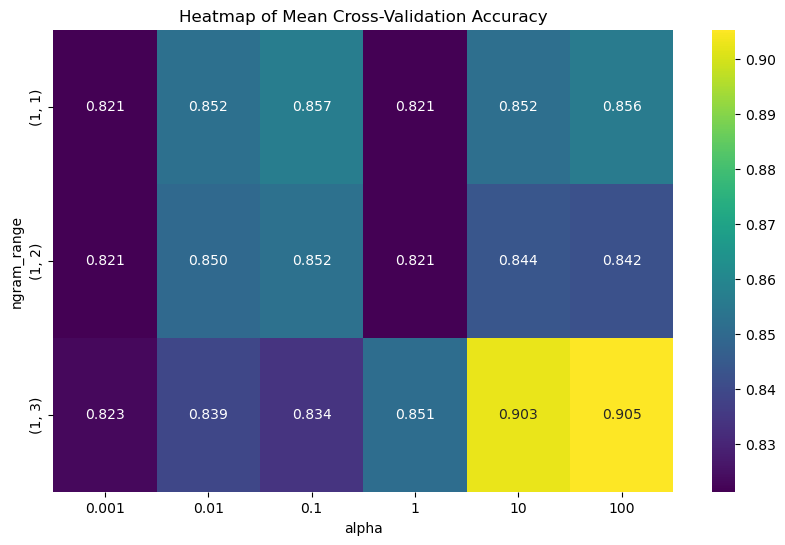

In [ ]:
# Get the number of unique values for each parameter
n_ngram_range = len(param_grid['tfidfvectorizer__ngram_range'])
n_alpha = len(param_grid['linearsvc__C'])

# Reshape the scores array based on the number of unique values
scores = grid.cv_results_['mean_test_score'][:n_ngram_range * n_alpha].reshape(n_ngram_range, n_alpha)

# Create a heatmap using seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(scores, annot=True, fmt=".3f", xticklabels=param_grid['linearsvc_C'], yticklabels=param_grid['tfidfvectorizer__ngram_range'], cmap='viridis')
plt.xlabel('C')
plt.ylabel('ngram_range')
plt.title('Heatmap of Gridsearch f1 scores')
plt.show()

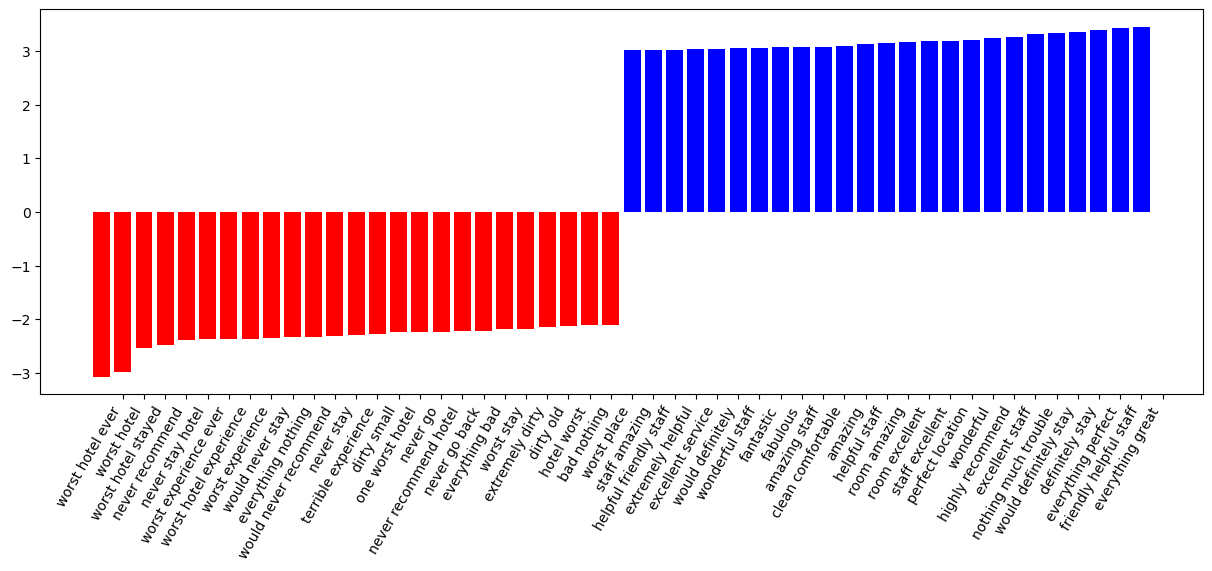

In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    coef = classifier.feature_log_prob_[1] - classifier.feature_log_prob_[0]
    top_positive_coefficients = np.argsort(coef)[-n_top_features:]
    top_negative_coefficients = np.argsort(coef)[:n_top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()

vectorizer = grid.best_estimator_.named_steps['tfidfvectorizer']
X_train_transformed = vectorizer.transform(X_train)
clf = grid.best_estimator_.named_steps['complementnb']
visualize_coefficients(clf, vectorizer.get_feature_names_out())
